### CNN 프로젝트

#### 주제

- 색깔별, 종류별 의류 이미지 다중 분류

#### 데이터 수집 링크

- kaggle: https://www.kaggle.com/datasets/trolukovich/apparel-images-dataset


#### 목차

1. 데이터(이미지) 탐색
2. 학습/검증/테스트 데이터(이미지) 분리 및 파일 처리
3. 사전 훈련 모델 학습 및 예측, 평가
    1) VGG16
    2) XCeption
    3) ResNet50
    4) MobileNetV2
4. 모델별 예측 정확도 비교
5. 느낀 점

#### 1. 데이터(이미지) 탐색

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/clothes/original/'

idg = ImageDataGenerator(rescale=1./255)
generator = idg.flow_from_directory(root, target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=True)

print(generator.class_indices)

Found 11385 images belonging to 24 classes.
{'black_dress': 0, 'black_pants': 1, 'black_shirt': 2, 'black_shoes': 3, 'black_shorts': 4, 'blue_dress': 5, 'blue_pants': 6, 'blue_shirt': 7, 'blue_shoes': 8, 'blue_shorts': 9, 'brown_pants': 10, 'brown_shoes': 11, 'brown_shorts': 12, 'green_pants': 13, 'green_shirt': 14, 'green_shoes': 15, 'green_shorts': 16, 'red_dress': 17, 'red_pants': 18, 'red_shoes': 19, 'white_dress': 20, 'white_pants': 21, 'white_shoes': 22, 'white_shorts': 23}


- 총 24개 종류의 타겟을 가진 약 11,385개의 이미지로 구성되어 있음을 알 수 있습니다.
- 무작위로 이미지 1개를 선정하여 실제로 어떻게 구성되어 있는지 확인해봅니다.

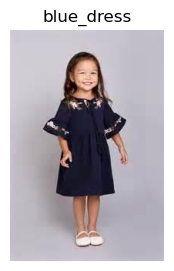

In [2]:
import cv2
import matplotlib.pyplot as plt
import random

random_idx = random.randint(0, 11384)

image = cv2.cvtColor(cv2.imread(generator.filepaths[random_idx]), cv2.COLOR_BGR2RGB)
label = [k for k, v in generator.class_indices.items() if v == generator.classes[random_idx]][0]

def show_image(image):
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
    plt.show()

show_image(image)

#### 2. 학습/검증/테스트 데이터(이미지) 분리 및 파일 처리

- 이미지 데이터를 분리하기 위해 각 파일의 경로와 타겟을 데이터프레임으로 만들어줍니다.

In [3]:
target_name = {v: k for k, v in generator.class_indices.items()}
target_name

{0: 'black_dress',
 1: 'black_pants',
 2: 'black_shirt',
 3: 'black_shoes',
 4: 'black_shorts',
 5: 'blue_dress',
 6: 'blue_pants',
 7: 'blue_shirt',
 8: 'blue_shoes',
 9: 'blue_shorts',
 10: 'brown_pants',
 11: 'brown_shoes',
 12: 'brown_shorts',
 13: 'green_pants',
 14: 'green_shirt',
 15: 'green_shoes',
 16: 'green_shorts',
 17: 'red_dress',
 18: 'red_pants',
 19: 'red_shoes',
 20: 'white_dress',
 21: 'white_pants',
 22: 'white_shoes',
 23: 'white_shorts'}

In [4]:
target_names = []
for target in generator.classes:
    target_names.append(target_name[target])
print(target_names.__len__())

11385


In [5]:
import pandas as pd

original_df = pd.DataFrame({'file_paths': generator.filepaths, 'target_names': target_names, 'targets': generator.classes})
original_df.loc[:, 'file_paths'] = original_df.file_paths.apply(lambda x: x.replace('\\', '/'))

display(original_df)

,file_paths,target_names,targets
0,./datasets/clothes/original/black_dress/009796...,black_dress,0
1,./datasets/clothes/original/black_dress/038098...,black_dress,0
2,./datasets/clothes/original/black_dress/052217...,black_dress,0
3,./datasets/clothes/original/black_dress/056171...,black_dress,0
4,./datasets/clothes/original/black_dress/06130b...,black_dress,0
...,...,...,...
11380,./datasets/clothes/original/white_shorts/f0be9...,white_shorts,23
11381,./datasets/clothes/original/white_shorts/f3525...,white_shorts,23
11382,./datasets/clothes/original/white_shorts/f50bf...,white_shorts,23
11383,./datasets/clothes/original/white_shorts/fb625...,white_shorts,23


- 데이터프레임으로부터 `sklearn`의 `train_test_split()`을 사용하여 학습/검증/테스트 데이터를 분리합니다.

In [6]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_targets, test_targets = \
train_test_split(original_df.file_paths, original_df.targets, stratify=original_df.targets, test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(test_targets.value_counts())

targets
1     697
20    654
17    640
6     638
3     613
7     593
2     572
19    488
22    480
8     418
5     402
11    371
15    364
0     360
4     262
10    249
18    247
9     239
21    219
14    184
13    182
16    108
23     96
12     32
Name: count, dtype: int64
targets
1     174
20    164
17    160
6     160
3     153
7     148
2     143
19    122
22    120
8     105
5     100
11     93
15     91
0      90
4      66
10     62
18     61
9      60
21     55
14     46
13     45
16     27
23     24
12      8
Name: count, dtype: int64


In [7]:
train_images, validation_images, train_targets, validation_targets = \
train_test_split(train_images, train_targets, stratify=train_targets, test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())

targets
1     558
20    523
17    512
6     510
3     490
7     474
2     458
19    390
22    384
8     334
5     322
11    297
15    291
0     288
4     210
10    199
18    198
9     191
21    175
14    147
13    146
16     86
23     77
12     26
Name: count, dtype: int64
targets
1     139
20    131
17    128
6     128
3     123
7     119
2     114
19     98
22     96
8      84
5      80
11     74
15     73
0      72
4      52
10     50
18     49
9      48
21     44
14     37
13     36
16     22
23     19
12      6
Name: count, dtype: int64


- 분리한 데이터들을 각각 원본 데이터프레임으로부터 인덱스로 추출하여 별도의 데이터프레임으로 분리합니다.

In [8]:
train_df = original_df.iloc[train_images.index].reset_index(drop=True)
validation_df = original_df.iloc[validation_images.index].reset_index(drop=True)
test_df = original_df.iloc[test_images.index].reset_index(drop=True)

print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(7286, 3)
(1822, 3)
(2277, 3)


- 실제 이미지 파일들을 학습/검증/테스트 데이터로 분리한 바에 맞게 폴더를 나누어 복사해줍니다.

In [20]:
import shutil
import os

root = './datasets/clothes/'

for file_path in train_images:
    clothes_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'train/' + clothes_dir)

    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)
    
for file_path in validation_images:
    clothes_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'validation/' + clothes_dir)

    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)

for file_path in test_images:
    clothes_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'test/' + clothes_dir)

    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)

#### 3. 사전 훈련 모델 학습, 예측 및 평가

- 먼저 `keras` 라이브러리의 `Sequence` 클래스를 상속 받는 `Dataset` 클래스를 만들어 이후 훈련에 활용하고자 합니다.
- 해당 클래스를 만드는 목적은 `__len__()`, `__getitem__()`, `on_epoch_end()`등의 메소드를 재정의함으로써,  
  이미지를 불러올 때 `augmentation`을 적용하거나 스케일링 관련 `preprocess function`을 적용하기 위함입니다.

In [9]:
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

IMAGE_SIZE = 64
BATCH_SIZE = 64

class Dataset(Sequence):
    def __init__(self, file_paths, targets, batch_size=BATCH_SIZE, aug=None, preprocess=None, shuffle=False):
        self.file_paths = file_paths
        self.targets = targets
        self.batch_size = batch_size
        self.aug = aug
        self.preprocess = preprocess
        self.shuffle = shuffle

        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.targets) / self.batch_size))

    def __getitem__(self, index):
        file_paths_batch = self.file_paths[index * self.batch_size: (index + 1) * self.batch_size]
        targets_batch = self.targets[index * self.batch_size: (index + 1) * self.batch_size]

        results_batch = np.zeros((file_paths_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

        for i in range(file_paths_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(file_paths_batch[i]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

            if self.aug is not None:
                image = self.aug(image=image)['image']

            if self.preprocess is not None:
                image = self.preprocess(image)

            results_batch[i] = image

        return results_batch, targets_batch

    def on_epoch_end(self):
        if self.shuffle:
            self.file_paths, self.targets = shuffle(self.file_paths, self.targets)
            

- 다음은 `create_model()` 함수를 정의합니다.
- 해당 함수의 목적은 전달 받은 사전 훈련 모델의 종류에 따라 `Convolution Backbone` 층을 알맞게 사용하고,  
  이후 훈련할 데이터의 타겟에 맞게 분류기(`Classifier Layer`)를 재정의하여 `concatenate`하기 위함입니다.

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': 
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(24, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)

    if verbose:
        model.summary()
    else:
        pass

    return model

#### 1) VGG16 모델
- 학습/검증/테스트 데이터의 파일 경로와 타겟 데이터를 통해 `Dataset`객체를 생성합니다.

In [24]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

train_dataset = Dataset(train_file_paths, train_targets, batch_size=BATCH_SIZE, preprocess=vgg_preprocess_input, shuffle=True)
validation_dataset = Dataset(validation_file_paths, validation_targets, batch_size=BATCH_SIZE, preprocess=vgg_preprocess_input)
test_dataset = Dataset(test_file_paths, test_targets, batch_size=BATCH_SIZE, preprocess=vgg_preprocess_input)

- VGG16 사전훈련모델을 활용한 `model`객체를 생성합니다.

In [25]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model = create_model(model_name='vgg16', verbose=True)
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 50)                  │          25,6

 Total params: 14,741,562 (56.23 MB)

 Trainable params: 14,741,562 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

- 콜백을 정의합니다.
- `ModelCheckpoint`를 통해 `epoch`마다 가중치를 파일로 내보내 저장합니다.
- `ReduceLROnPlateau`를 통해 `val_loss`의 변화에 따라 학습률을 동적으로 조정합니다.
- `EarlyStopping`을 통해 `val_loss`가 일정 `epoch` 반복 동안 감소하지 않을 경우 학습을 조기 종료합니다.

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/clothes/vgg16/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

- `gc`를 통해 메모리를 최적화한 후, `fit()`을 통해 훈련을 진행합니다.

In [27]:
import gc

gc.collect()

22809

In [15]:
N_EPOCHS = 10

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/10


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


114/114 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - acc: 0.0772 - loss: 10.5246 - val_acc: 0.1894 - val_loss: 2.6137 - learning_rate: 0.0010
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - acc: 0.2567 - loss: 2.3747 - val_acc: 0.4385 - val_loss: 1.7851 - learning_rate: 0.0010
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - acc: 0.4807 - loss: 1.6513 - val_acc: 0.6010 - val_loss: 1.2397 - learning_rate: 0.0010
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - acc: 0.6464 - loss: 1.1549 - val_acc: 0.6987 - val_loss: 0.9610 - learning_rate: 0.0010
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - acc: 0.7166 - loss: 0.8960 - val_acc: 0.7338 - val_loss: 0.8730 - learning_rate: 0.0010
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - acc: 0.7627 - loss: 0.7578 - val_acc: 0.7903 - val_loss: 0.7437 - learning_rate: 0.0010
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - acc: 0.8028 - loss: 0.6082 - val_acc: 0.7881 - val_loss: 0.6957 - learning_rate: 0.0010
Epoch 8/1

- epochs 수를 더 늘려 추가학습을 진행합니다.

In [28]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# model = create_model(model_name='vgg16', verbose=False)
model.load_weights('./callback_files/clothes/vgg16/weights.010-0.6147-0.8603.weights.h5')
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

In [29]:
N_EPOCHS = 10

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - acc: 0.8264 - loss: 0.5895 - val_acc: 0.8293 - val_loss: 0.5849 - learning_rate: 0.0010
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - acc: 0.8822 - loss: 0.3910 - val_acc: 0.8441 - val_loss: 0.5721 - learning_rate: 0.0010
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - acc: 0.8887 - loss: 0.3871 - val_acc: 0.8353 - val_loss: 0.5616 - learning_rate: 0.0010
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - acc: 0.8937 - loss: 0.3499 - val_acc: 0.8589 - val_loss: 0.5028 - learning_rate: 0.0010
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - acc: 0.9064 - loss: 0.2987 - val_acc: 0.8430 - val_loss: 0.5522 - learning_rate: 0.0010
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - acc: 0.9182 - loss: 0.2770 - val_acc: 0.8474 - val_loss: 0.5816 - learning_rate: 0.0010
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - acc: 0.9459 - loss: 0.1822 - val_acc: 0.8842 - val_loss: 0.4493 - learning_rate: 1.0000

- `evaluate()`을 통해 테스트 데이터에 대한 예측을 평가하고,  
  학습 데이터에 대한 정확도와 검증 데이터에 대한 정확도의 변화를 시각화합니다.

In [30]:
model.evaluate(test_dataset)

36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 689ms/step - acc: 0.8785 - loss: 0.5945


[0.5760558843612671, 0.8814229369163513]

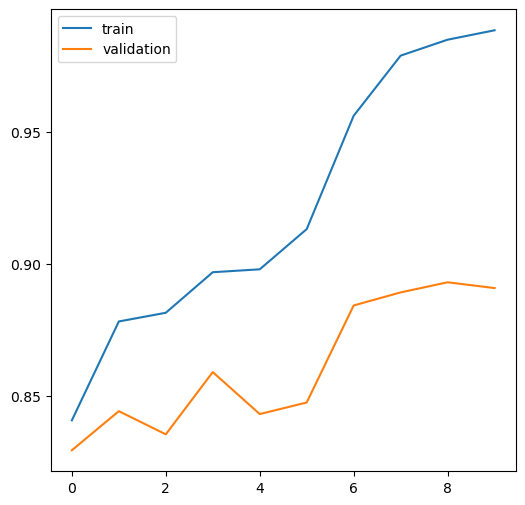

In [31]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.show()

show_history(history)

#### 2) Xception 모델
- 이하 과정은 vgg16 모델과 동일하므로, 앞으로의 사전훈련모델 사용 부분에서는 코드에 대한 설명을 생략합니다.

In [32]:
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

train_dataset = Dataset(train_file_paths, train_targets, batch_size=BATCH_SIZE, preprocess=xception_preprocess_input, shuffle=True)
validation_dataset = Dataset(validation_file_paths, validation_targets, batch_size=BATCH_SIZE, preprocess=xception_preprocess_input)
test_dataset = Dataset(test_file_paths, test_targets, batch_size=BATCH_SIZE, preprocess=xception_preprocess_input)

In [33]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model = create_model(model_name='xception', verbose=True)
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 31, 31, 32)        │             864 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_bn               │ (None, 31, 31, 32)        │             128 │ block1_conv1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_act (Activation) │ (None, 31, 31, 32)        │               0 │ block1_conv1_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 29, 29, 64)        │          18,432 │ block1_conv1_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_bn               │ (None, 29, 29, 64)        │             256 │ block1_conv2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_act (Activation) │ (None, 29, 29, 64)        │               0 │ block1_conv2_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1               │ (None, 29, 29, 128)       │           8,768 │ block1_conv2_act[0][0]     │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1_bn            │ (None, 29, 29, 128)       │             512 │ block2_sepconv1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_act           │ (None, 29, 29, 128)       │               0 │ block2_sepconv1_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2               │ (None, 29, 29, 128)       │          17,536 │ block2_sepconv2_act[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_bn            │ (None, 29, 29, 128)       │             512 │ block2_sepconv2[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 15, 15, 128)       │           8,192 │ block1_conv2_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 15, 15, 128)       │               

 Total params: 20,965,154 (79.98 MB)

 Trainable params: 20,910,626 (79.77 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/clothes/xception/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

In [35]:
import gc

gc.collect()
N_EPOCHS = 20

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - acc: 0.1883 - loss: 2.8301 - val_acc: 0.3924 - val_loss: 2.8659 - learning_rate: 0.0010
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - acc: 0.5702 - loss: 1.5833 - val_acc: 0.7316 - val_loss: 2.5315 - learning_rate: 0.0010
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - acc: 0.8121 - loss: 0.7457 - val_acc: 0.7925 - val_loss: 1.2968 - learning_rate: 0.0010
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - acc: 0.8925 - loss: 0.4889 - val_acc: 0.8611 - val_loss: 0.6413 - learning_rate: 0.0010
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - acc: 0.9125 - loss: 0.3691 - val_acc: 0.7585 - val_loss: 1.5779 - learning_rate: 0.0010
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - acc: 0.9267 - loss: 0.3080 - val_acc: 0.8436 - val_loss: 0.9025 - learning_rate: 0.0010
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - acc: 0.9423 - loss: 0.2486 - val_acc: 0.9391 - val_loss: 0.2952 - learning_rate: 1.0000

In [36]:
model.evaluate(test_dataset)

36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 424ms/step - acc: 0.9527 - loss: 0.2642


[0.27535104751586914, 0.9490557909011841]

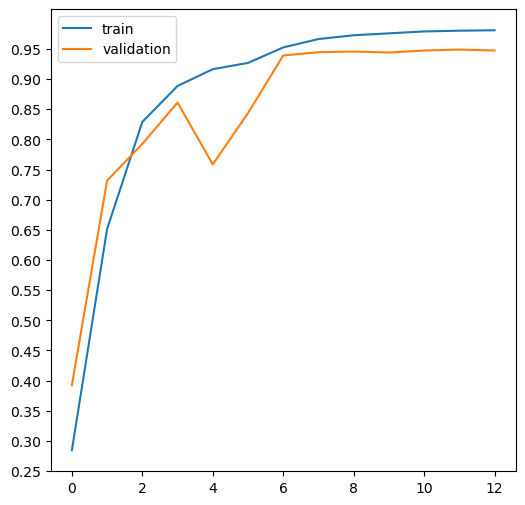

In [37]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.show()

show_history(history)

#### 3) ResNet50 모델

In [38]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

train_dataset = Dataset(train_file_paths, train_targets, batch_size=BATCH_SIZE, preprocess=resnet_preprocess_input, shuffle=True)
validation_dataset = Dataset(validation_file_paths, validation_targets, batch_size=BATCH_SIZE, preprocess=resnet_preprocess_input)
test_dataset = Dataset(test_file_paths, test_targets, batch_size=BATCH_SIZE, preprocess=resnet_preprocess_input)

In [39]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model = create_model(model_name='resnet50', verbose=True)
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 70, 70, 3)         │               0 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 32, 32, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 34, 34, 64)        │               0 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 16, 16, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_bn        │ (None, 16, 16, 64)        │             256 │ pool1_pool[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_relu      │ (None, 16, 16, 64)        │               0 │ conv2_block1_preact_bn[0]… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 16, 16, 64)        │           4,096 │ conv2_block1_preact_relu[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 16, 16, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 16, 16, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_pad            │ (None, 18, 18, 64)        │               0 │ conv2_block1_1_relu[0][0]  │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 16, 16, 64)        │          36,864 │ conv2_block1_2_pad[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 16, 16, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 16, 16, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │               

 Total params: 23,668,474 (90.29 MB)

 Trainable params: 23,623,034 (90.11 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/clothes/resnet50/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

In [41]:
import gc

gc.collect()
N_EPOCHS = 20

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - acc: 0.3408 - loss: 2.4733 - val_acc: 0.6103 - val_loss: 4.4993 - learning_rate: 0.0010
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - acc: 0.7336 - loss: 1.0705 - val_acc: 0.5549 - val_loss: 2.9792 - learning_rate: 0.0010
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - acc: 0.7925 - loss: 0.8354 - val_acc: 0.8079 - val_loss: 1.0440 - learning_rate: 0.0010
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - acc: 0.8557 - loss: 0.5628 - val_acc: 0.8255 - val_loss: 0.9194 - learning_rate: 0.0010
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - acc: 0.8822 - loss: 0.4793 - val_acc: 0.7206 - val_loss: 1.6489 - learning_rate: 0.0010
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - acc: 0.8951 - loss: 0.4288 - val_acc: 0.8397 - val_loss: 0.8259 - learning_rate: 0.0010
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - acc: 0.9232 - loss: 0.3356 - val_acc: 0.8952 - val_loss: 0.4816 - learning_rate: 0.0010

In [42]:
model.evaluate(test_dataset)

36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 440ms/step - acc: 0.9253 - loss: 0.3902


[0.40283116698265076, 0.921826958656311]

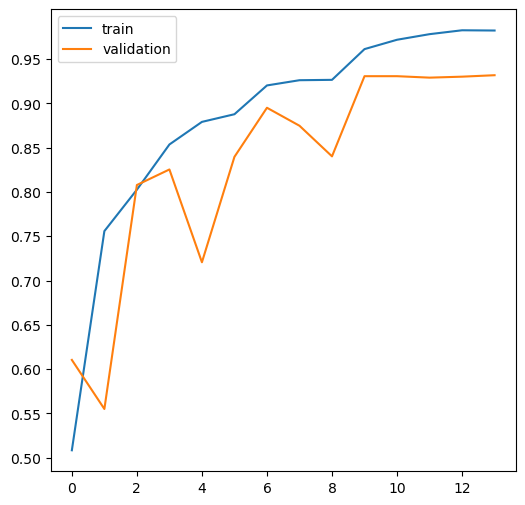

In [43]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.show()

show_history(history)

#### 4) MobileNetV2 모델

In [44]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess_input

train_file_paths = train_df['file_paths'].values
train_targets = train_df['targets'].values

validation_file_paths = validation_df['file_paths'].values
validation_targets = validation_df['targets'].values

test_file_paths = test_df['file_paths'].values
test_targets = test_df['targets'].values

train_dataset = Dataset(train_file_paths, train_targets, batch_size=BATCH_SIZE, preprocess=mobilenet_preprocess_input, shuffle=True)
validation_dataset = Dataset(validation_file_paths, validation_targets, batch_size=BATCH_SIZE, preprocess=mobilenet_preprocess_input)
test_dataset = Dataset(test_file_paths, test_targets, batch_size=BATCH_SIZE, preprocess=mobilenet_preprocess_input)

In [45]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model = create_model(model_name='mobilenet', verbose=True)
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

C:\Users\hyuns\AppData\Local\Temp\ipykernel_6868\3875128704.py:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 32, 32, 32)        │             864 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 32, 32, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 32, 32, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 32, 32, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 32, 32, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 32, 32, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 32, 32, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 32, 32, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 32, 32, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 32, 32, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 32, 32, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 33, 33, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 16, 16, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,323,258 (8.86 MB)

 Trainable params: 2,289,146 (8.73 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/clothes/mobilenet/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

In [47]:
import gc

gc.collect()
N_EPOCHS = 20

history = model.fit(train_dataset,
                    batch_size=BATCH_SIZE,
                    epochs=N_EPOCHS, 
                    validation_data=validation_dataset, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 95s 600ms/step - acc: 0.1956 - loss: 3.0345 - val_acc: 0.2069 - val_loss: 6.2112 - learning_rate: 0.0010
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 67s 581ms/step - acc: 0.6862 - loss: 1.2116 - val_acc: 0.3090 - val_loss: 6.9168 - learning_rate: 0.0010
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 67s 573ms/step - acc: 0.8138 - loss: 0.7586 - val_acc: 0.2700 - val_loss: 7.9571 - learning_rate: 0.0010
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 67s 580ms/step - acc: 0.8681 - loss: 0.5237 - val_acc: 0.3754 - val_loss: 7.5105 - learning_rate: 1.0000e-04
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 68s 589ms/step - acc: 0.9024 - loss: 0.3890 - val_acc: 0.4446 - val_loss: 6.5510 - learning_rate: 1.0000e-04


In [48]:
model.evaluate(test_dataset)

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 261ms/step - acc: 0.4290 - loss: 6.8239


[6.754436492919922, 0.43126922845840454]

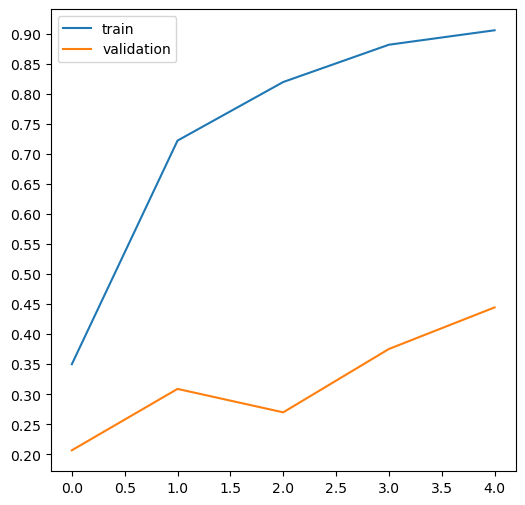

In [49]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.show()

show_history(history)

#### 4. 모델별 예측 정확도 비교

- 각 사전훈련모델 별 학습 데이터에서의 정확도와 검증 데이터에서의 정확도,  
  그리고 `evaluate()`를 통한 테스트 데이터에서의 예측 정확도는 아래와 같습니다.

#### 1. VGG16 모델

**Epoch 20/20**
- train_acc: 0.9882, train_loss: 0.0442, val_acc: 0.8908, val_loss: 0.5209
- test_acc: 0.8785, test_loss: 0.5945

#### 2. Xception 모델

**Epoch 13/20 (EarlyStopping 적용)**
- train_acc: 0.9810, train_loss: 0.0812, val_acc: 0.9473, val_loss: 0.2787
- test_acc: 0.9527, test_loss: 0.2642

#### 3. ResNet50 모델

**Epoch 14/20 (EarlyStopping 적용)**
- train_acc: 0.9811, train_loss: 0.0820, val_acc: 0.9319, val_loss: 0.3600
- test_acc: 0.9253, test_loss: 0.3902

#### 4. MobileNetV2 모델

**Epoch 5/20 (EarlyStopping 적용)**
- train_acc: 0.9024, train_loss: 0.3890, val_acc: 0.4446, val_loss: 6.5510
- test_acc: 0.4290, test_loss: 6.8239

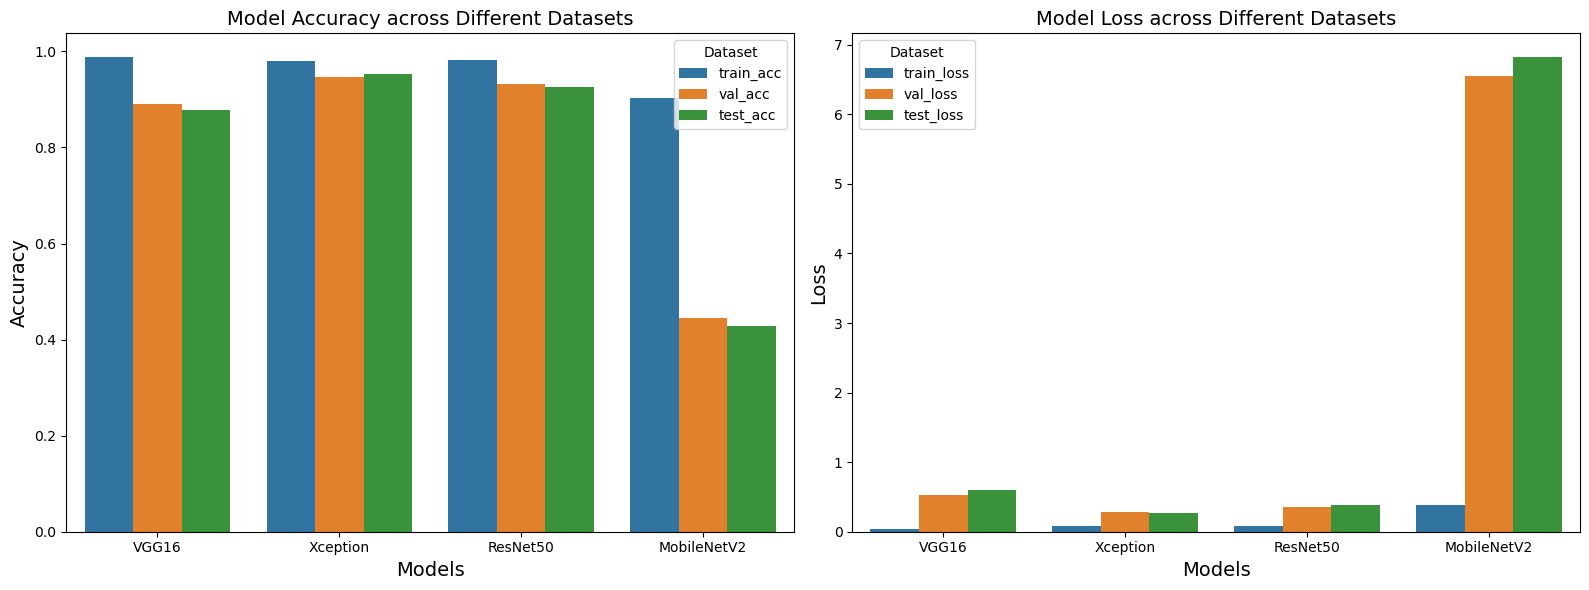

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

score_df = pd.DataFrame({
    'Models': ['VGG16', 'Xception', 'ResNet50', 'MobileNetV2'],
    'train_acc': [0.9882, 0.9810, 0.9811, 0.9024],
    'val_acc': [0.8908, 0.9473, 0.9319, 0.4446],
    'test_acc': [0.8785, 0.9527, 0.9253, 0.4290],
    'train_loss': [0.0442, 0.0812, 0.0820, 0.3890],
    'val_loss': [0.5209, 0.2787, 0.3600, 6.5510],
    'test_loss': [0.5945, 0.2642, 0.3902, 6.8239]
})

acc_df = score_df.melt(id_vars='Models', value_vars=['train_acc', 'val_acc', 'test_acc'], var_name='Dataset', value_name='Accuracy')
loss_df = score_df.melt(id_vars='Models', value_vars=['train_loss', 'val_loss', 'test_loss'], var_name='Dataset', value_name='Loss')

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x='Models', y='Accuracy', hue='Dataset', data=acc_df, ax=axs[0])
axs[0].set_title('Model Accuracy across Different Datasets', fontsize=14)
axs[0].set_xlabel('Models', fontsize=14)
axs[0].set_ylabel('Accuracy', fontsize=14)

sns.barplot(x='Models', y='Loss', hue='Dataset', data=loss_df, ax=axs[1])
axs[1].set_title('Model Loss across Different Datasets', fontsize=14)
axs[1].set_xlabel('Models', fontsize=14)
axs[1].set_ylabel('Loss', fontsize=14)

plt.tight_layout()
plt.show()

#### 5. 🚩느낀 점

- 4가지 사전훈련모델을 활용하여 의류 이미지에 대한 분류 예측을 수행한 결과,  
  `Xception` 모델의 성능이 가장 높게 나타났습니다.
- 그러나 비교적 단순하게 구성된 모델인 `VGG16` 모델의 성능이 `Xception` 모델과 큰 차이를 보이지 않는다는 사실에 놀랐습니다.
- 한편 `MobileNetV2` 모델을 사용하였을 때에는 다른 사전 훈련된 모델들에 비해 성능이 저조한 것을 확인할 수 있었습니다.
- `MobileNetV2`는 경량화된 네트워크 아키텍처로, 모바일 및 임베디드 환경에서의 효율적인 성능을 목표로 설계되었습니다.  
  그러나 이러한 경량화 특성 때문에, 더 복잡하고 다양한 이미지를 포함한 데이터셋에서는 세부적인 특징을 충분히 학습하지 못하는 한계를 보였습니다.  
  따라서 더 복잡한 모델인 `Xception`, `ResNet50` 등과 비교했을 때, `MobileNetV2`의 성능이 떨어지는 결과가 나타났습니다.  
- 이러한 결과를 보며 **모델 선택 시 데이터셋의 특성과 모델의 설계 목적을 신중하게 고려해야 한다**는 사실을 깨달았습니다.  